# Preliminaries : Particle classification challenge
Data preprocessing in order to feed our CNN. 

## Contents of this notebook
1. Simulation. 
2. Read data.
3. Reduce the size of the data, i.e. get exactly what we need (this is kind of preprocessing the data).
4. Save the reduced data for further use. 

## Previous considerations:
* the algorithm only works approximately if h and w are <<< im.shape . Otherwise, the algorithm will cut the image. 

* In order to account for this issue, what can be done is 

    1. reduce only the big axis, the one with
    2. modify the algorithm 

## Considerations: file size
In order to save memory, our data set must me made of these images. It can be stored in a cv file, or in a root tree. We will see how efficient is the root tree. Options: 

* use csv files with delimiter ',' : 200x200 img is ~900K
* use numpy.save : 200x200 img is ~300K
* use ROOT trees: 200x200 img is ~33K
* use png images: The data is not properly conserved, we do not have the numerical values but rather a png image that approximate this values. 

As far as disc memory is concerned, probably the best option to tackle this problem is using ROOT trees.

This reduction algorithim could be uploaded into lxplus and then download the reduced data. Consequently, 1000 $e^{-}$ and 1000 $\mu^{-}$ waveforms must be around 60MB and 1 million waveforms 30 GB. I believe this 30 GB is a very reasonable number.  

## Note: Particle classification challenge

1. Binary classification between electrons and muons 
    * 10k $e^{-}$ and 10k $\mu^{-}$.
    * It is estimated that the size of the 20k reduced images (our data files) are 600 MB. 
2. Multiparticle classification 
    * 10k $e^{-}$, $\mu^{-}$, $p^{+}$, $\pi^{-}$ and gamma ray $\gamma$. In total, 50k particles.
    * about 1500 MB.  
3. Simulation data
    * This data comes from a numerical simulation, and therefore we have to thank Jose Soto for the good performance in regards to this simulation . Without him, this project might have not been possible...     
    * We wish to study how effective is particle classification regarding the energy of the different particles. This may answer the question How difficult it is to tell the difference between particles at different energies.
             
          

## Deep learning considerations

Now our data is ready to feed our Deep Neural networks.

Conviene reducir a 100x100 pixeles

* bloque convolutivo
 1. kernel(5...7...9)
 2. bajar después+pooling (2x2)
* salida
 1. confusion matrix
 2. evolucion del fitness en funcion de la epoca

# 1. SIMULATION

We have a Liquid Argon dual phase detector whose dimensions are 3x1x1 (see figure). https://twiki.cern.ch/twiki/bin/view/Sandbox/RecoMCSamples3x1x1 (Link to see more info about the variables and the simulation)
<img src="./images/detector.png" alt="Detector"
	title="A cute detector" width="500" height="500" />
    
We can also define our coordinate system in terms of spherical coordinates.
<img src="./images/angle_definition.png" alt="Detector"
	title="A cute detector" width="400" height="400" />
    
## wierd convention

Note that this coordinate system does not follow the usual convection, i.e. $\bf{x}\wedge\bf{y}=\bf{z}$. In this case you can check that $\bf{x}\wedge\bf{y}=-\bf{z}$ . This may lead to some confusion in the future, so keep it in mind.

## Generation

### 1. Low energy sample

The generation parameters are: 

| generator parameter |   value |
|:-:|:-:|
|  physics.producers.generator.PDG: |  [11] |
|  physics.producers.generator.P0:  |  [5.] |
| physics.producers.generator.PDist:   | 0  |
|  physics.producers.generator.SigmaP:  | [5.]  |
| physics.producers.generator.T0:   |   [0]  |
|physics.producers.generator.TDist: |   0  |
|physics.producers.generator.SigmaT: | [0]|
| physics.producers.generator.X0: | [0.0]|
|physics.producers.generator.Y0: | [0.0]|
|hysics.producers.generator.Z0:  | [0.0]|
| physics.producers.generator.PosDist:| 0| 
| physics.producers.generator.SigmaX:|[0.] | 
|physics.producers.generator.SigmaY: | [0.]| 
|physics.producers.generator.SigmaZ: |[0.]| 
| physics.producers.generator.Theta0XZ: |[0.] | 
| physics.producers.generator.Theta0YZ: | [0.]| 
| physics.producers.generator.AngleDist: |0 |
|physics.producers.generator.SigmaThetaXZ: |[22.5] | 
| physics.producers.generator.SigmaThetaYZ:|[22.5] | 
|physics.producers.generator.PadOutVectors:|false|
|physics.producers.generator.ParticleSelectionMode: |"all" | 

#### Brief description:

* PDG stands for what type of particle is,i.e. the pdg code of the particle.
* P0 stands for the mean value of the generated momentum.
* PDist stands for the type of distribution. [0] means that the distribution is uniform.
* SigmaP stands for the deviation. In this case is the range for which you want the energy to be distributed.
* T0 stands for... the time event
* TDist stands for ... time event distribution
* SigmaT stands for... deviation time
* X0 stands for... the mean position
* Y0 stands for ... the mean position
* Z0 stands for ... the mean position
* PosDist stands for the type of the distribution, this case is linear. 
* Sigma X,Y,Z stand for the deviation. 
* Theta0XZ stands for the initial direction (angular) from the Z axis to X in the XZ plane... this is the code description
```
Comment("angle from Z axis on world X-Z plane (degrees)")
```
* AngleDist stands for the type of the distribution. [1] mean Gaussian
* SigmaThetaXZ stands for the standard deviation.
* PadOutVectors stands for do not know.
* ParticleSelectionMode stands for do not know.

The Relation between the angles defined in the simulation $(\theta_{XZ},\theta_{YZ})$ and the angles from the figure $(\theta ,\varphi)$ is not trivial. From the simulation (code) we know that: 
```
TLorentzVector pvec(p*std::cos(thyzrad)*std::sin(thxzrad),
                        p*std::sin(thyzrad),
                        p*std::cos(thxzrad)*std::cos(thyzrad),
                        std::sqrt(p*p+m*m));
```
For example, 
$$
\varphi=\arctan \frac{z}{y}=\cos\theta_{xz}\tan \theta_{yz}
$$
$$
\theta=\arctan \frac{\sqrt{z^{2}+y^{2}}}{x}
$$
So we have to be careful with the parameter simulation in order to generate the desired angles.

## Quantitative analysis

In [1]:
### Dependences
import numpy as np 
import uproot 
import matplotlib.pyplot as plt 

In [3]:
# Open the generator files
En=[]
x=[]
y=[]
z=[]
theta=[]
phi=[]
file = uproot.open("/scratch/deandres/MC/alongZ_2_3GeV/Electrons/gen/gen.root")
tree = file["analysistree"]["anatree"]
P = np.append(En,tree.array(b'MCTruth_Generator_StartMomentum').flatten())
PX = np.append(En,tree.array(b'MCTruth_Generator_StartMomentum_X').flatten())
PY = np.append(En,tree.array(b'MCTruth_Generator_StartMomentum_Y').flatten())
PZ = np.append(En,tree.array(b'MCTruth_Generator_StartMomentum_Z').flatten())
En = np.append(En,tree.array(b'MCTruth_Generator_StartEnergy').flatten())
x = np.append(x,tree.array(b'MCTruth_Generator_StartPoint_X').flatten())
y = np.append(y,tree.array(b'MCTruth_Generator_StartPoint_Y').flatten())
z = np.append(z,tree.array(b'MCTruth_Generator_StartPoint_Z').flatten())
theta = np.append(theta,tree.array(b'MCTruth_Generator_StartDirection_Theta').flatten())
phi = np.append(phi,tree.array(b'MCTruth_Generator_StartDirection_Phi').flatten())

In [4]:
tree.show() # display the branches within the tree

Run                        (no streamer)              asdtype('>i4')
Subrun                     (no streamer)              asdtype('>i4')
EventNumberInRun           (no streamer)              asdtype('>i4')
EventTimeSeconds           (no streamer)              asdtype('>i4')
EventTimeNanoseconds       (no streamer)              asdtype('>i4')
IsData                     (no streamer)              asdtype('int8')
MCTruth_Generator_NumberOfParticles
                           (no streamer)              asdtype('>i4')
MCTruth_Generator_ParticleID
                           (no streamer)              asjagged(asdtype('>i4'))
MCTruth_Generator_PDGCode  (no streamer)              asjagged(asdtype('>i4'))
MCTruth_Generator_Status   (no streamer)              asjagged(asdtype('>i4'))
MCTruth_Generator_Mass     (no streamer)              asjagged(asdtype('>f4'))
MCTruth_Generator_StartTime
                           (no streamer)              asjagged(asdtype('>f4'))
MCTruth_Generator_StartEnerg

In [8]:
x.shape

(50,)

# Energy and momentum

## 2-3 GeV
Particles whose energies range between 2 and 3 GeV

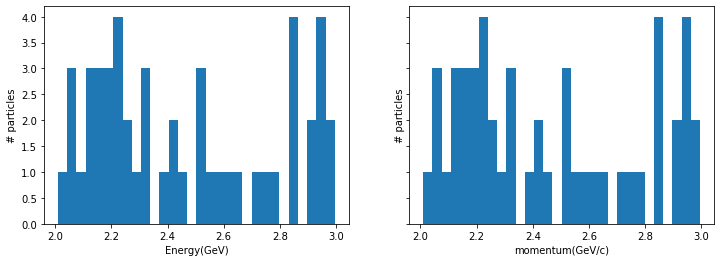

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axs[0].set_xlabel("Energy(GeV)")
axs[0].set_ylabel("# particles")
axs[0].hist(En.flatten(), bins=30)

axs[1].set_xlabel("momentum(GeV/c)")
axs[1].set_ylabel("# particles")
axs[1].hist(P.flatten(),bins=30)
plt.show()

# Initial position and angle distribution

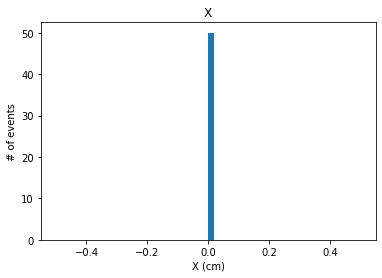

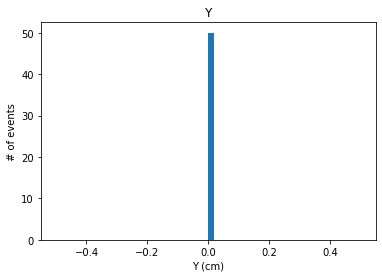

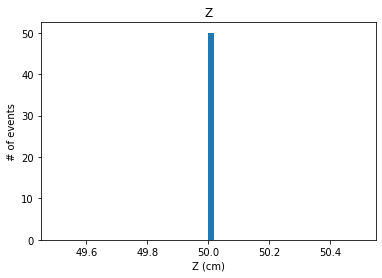

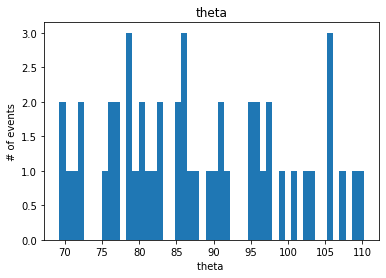

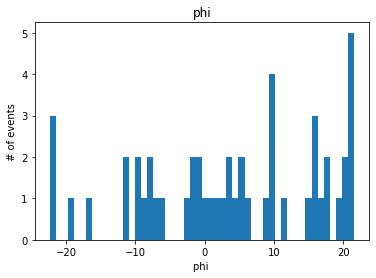

In [10]:
## initialize a vector of positions

fig = plt.figure()
plt.xlabel("X (cm)")
plt.ylabel("# of events")
plt.title("X")
plt.hist(x.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

fig = plt.figure()
plt.xlabel("Y (cm)")
plt.ylabel("# of events")
plt.title("Y")
plt.hist(y.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

fig = plt.figure()
plt.xlabel("Z (cm)")
plt.ylabel("# of events")
plt.title("Z")
plt.hist(z.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

fig = plt.figure()
plt.xlabel("theta ")
plt.ylabel("# of events")
plt.title("theta")
plt.hist(theta.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

fig = plt.figure()
plt.xlabel("phi ")
plt.ylabel("# of events")
plt.title("phi")
plt.hist(phi.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

In [12]:
def normalized(px,py,pz):
    norm=(px**2+py**2+pz**2)**0.5
    px = px/norm
    py = py/norm
    pz = pz/norm
    return px, py, pz
px,py,pz = normalized(PX,PY,PZ)

#define the angle distribution
theta = np.arccos(px) * 180/3.14
phi = np.arctan(py/pz) * 180/3.14

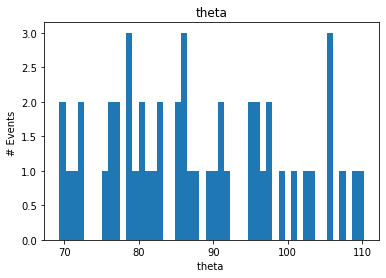

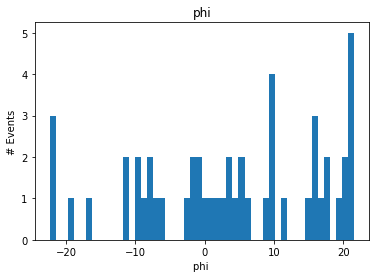

theta mean: 87.84514584011382 | variance: 11.479462681517884
phi mean: 3.7801348800976426 | variance: 12.821734220808706


In [13]:
fig = plt.figure()
plt.xlabel("theta ")
plt.ylabel("# Events ")
plt.title("theta")
plt.hist(theta.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

fig = plt.figure()
plt.xlabel("phi ")
plt.ylabel("# Events")
plt.title("phi")
plt.hist(phi.flatten(), bins=50) ## Energy uniformly distributed from 0 to 10 GeV
plt.show()

print('theta','mean:',theta.mean(),"|",'variance:', theta.var()**0.5)
print('phi','mean:',phi.mean(),"|",'variance:', phi.var()**0.5)

It looks like the distribution is normal in theta and uniformly distributed in phi

# 2.  READ DATA
## Problems with reco Waveform and Raw Waveform.
Apparently, reconstructed Waveforms and Raw Waveforms have different number of Channels. This is due to the fact that some of the channels are dead and are not taking into account during the reconstruction. The point is, different reconstructed Waveforms have different number of Channels for different Particles. This happens despite fact that the software use in the reconstruction is the same for different particles. 

|Particle||# Channels|
|:-:|:-:|
|electron||1280|
|proton||1280|
|pion||1280|
|photon||1229|
|muon||1229|

In contrast, the number of Channels for the Raw Wave forms is the same, i.e. 1280. This led us to the conclusion that, it is better to use the RawWaveforms instead. There is the possibility that we may use the reconstructed WaveForms, but we have to know what are the channels missing (this information is available) and perform some transformation, e.g. add the missing channels or delete them. 

In [14]:
########## dependencies ###########
import uproot  ### https://github.com/scikit-hep/uproot#exploring-a-ttree
import numpy as np
import matplotlib.pyplot as plt

In [17]:
file = uproot.open("/scratch/deandres/MC/alongZ_2_3GeV/Electrons/raw/raw.root")
print("the data contained in the file has the following keys: ",file[file.keys()[0]].keys())
print("We can access the data using")

the data contained in the file has the following keys:  [b'anatree;5', b'anatree;4']
We can access the data using


In [18]:
# we can display all the information stored in the TTree
tree=file["analysistree"]["anatree"] 
tree.show()

Run                        (no streamer)              asdtype('>i4')
Subrun                     (no streamer)              asdtype('>i4')
EventNumberInRun           (no streamer)              asdtype('>i4')
EventTimeSeconds           (no streamer)              asdtype('>i4')
EventTimeNanoseconds       (no streamer)              asdtype('>i4')
IsData                     (no streamer)              asdtype('int8')
RawWaveform_NumberOfChannels
                           (no streamer)              asdtype('>i4')
RawWaveform_NumberOfTicks  (no streamer)              asdtype('>i4')
RawWaveform_Channel        (no streamer)              asjagged(asdtype('>i4'))
RawWaveform_NumberOfTicksInAllChannels
                           (no streamer)              asdtype('>i4')
RawWaveform_ADC            (no streamer)              asjagged(asdtype('>i2'))
MCTruth_GEANT4_NumberOfDetectedPhotons
                           (no streamer)              asdtype('>i4')
MCTruth_GEANT4_DetectedPhoton_Channel
      

In [19]:
print(tree.array(b'RawWaveform_Channel')[1].shape) ## 1280 channels
print(tree.array( b'RawWaveform_NumberOfTicks')[1]) ## each channel 1667 ticks , the explanatory pdf is wrong!

(1280,)
1667


* It seems that theere are 1280 channels and 1667 ticks. 
* first view from 0 to 319 and second the rest (320-1280). 

In [74]:
##### This may not work in your computer, due to memory issues ####


#ADC = tree.array( b'RecoWaveform_ADC')
#NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
#Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
#NTracks=tree.array(b'NumberOfTracks')
#w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
#print(w,h)

## Unable to load the data !!!
If you run the code from above, you may notice that there is not enough memory to access all the data. Therefore, we may need to manage the memory usage. In order to do that, I found 2 ways: 

1. Lazy arrays: This method allows us to read the data on demand
2. Caching arrays: This method allows us to control the memory usage, in a Python dict.
3. Use PyROOT

What we did above is
```
ADC = tree.array( b'RecoWaveform_ADC')
```
And this array methods reas the file of cache immediately and returs in-memory array. This is why it is not working.

In [21]:
#1. Try Lazy arrays: 
##### from #https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray #####
#data = tree.lazyarrays(entrysteps=1)  
#ADC=data["RecoWaveform_ADC"] # This should gives us the number of events
# This contains a virtual array, which is read when any element of it is accessed, for instance0:33 / 4:16
#print(ADC[0])

# It appears that the code from above is not working
ADC=tree['RawWaveform_ADC']
print(ADC) # it seem this is an object called <TBranch b'RecoWaveform_ADC' at 0x7f226a47c828>

###### How to access this data #######
for i in range(0,500):
    basketcache={} # to refresh the memory stored, if you comment this line the pc will explode !!!!!!!!!!!!
    lazy=ADC.lazyarray(basketcache=basketcache) # this should work 
    #print(lazy[i])
    #print(basketcache.keys())
# we are really using the same memmory twice, this means that 

<TBranch b'RawWaveform_ADC' at 0x7f01906a78d0>


In [46]:
#w=1280
#h=1667
#for i in range(0,100):
#    Event=i
#    basketcache={}
#    im=lazy[Event].reshape((w,h))
#   v1=im[0:320,:]
#    v2=im[320:,:]
#    fig = plt.figure()
#    plt.imshow(v1.T,cmap = 'jet', interpolation='none')
#    plt.ylabel("Ticks, drift time ")
#    plt.xlabel("channel")
#    fig.set_size_inches(15, 15)
#    plt.show()
    #plt.imshow(v2.T,cmap = 'jet', interpolation='none') ##grey scale
#    plt.show()

# it works!!!!!! therefore, we will use lazy arrays.

# Electrons
Aparently there are lots of images that are empty, seems that the particles have not passed through the detector. We are going to studying what is going on... 
As we can see the second image is empty, let us focus on the second event.

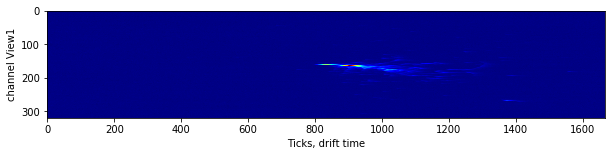

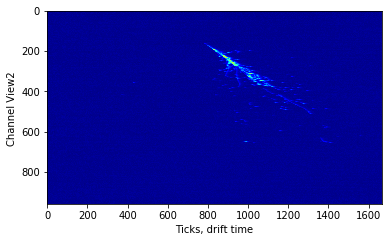

The event is generated according to the following parameters
E =  2.97 GeV
----------------------------------------
x0 =  0.0
y0 =  0.0
z0 =  50.0
----------------------------------------
theta0 =  107.23
phi0 =  3.86


In [47]:
Event=10
basketcache={}
im=lazy[Event].reshape((w,h))
v1=im[0:320,:]
v2=im[320:,:]
fig = plt.figure()
plt.imshow(v1,cmap = 'jet', interpolation='none')
fig.set_size_inches(10, 10)
plt.ylabel("channel View1")
plt.xlabel("Ticks, drift time")
plt.show()
plt.imshow(v2,cmap = 'jet', interpolation='none') ##grey scale
fig.set_size_inches(10, 10)
plt.ylabel("Channel View2 ")
plt.xlabel("Ticks, drift time")
plt.show()

print("The event is generated according to the following parameters")
print("E = ",round(En[Event],2), 'GeV')
print("-"*40)
print('x0 = ',round(x[Event],2))
print('y0 = ',round(y[Event],2))
print('z0 = ',round(z[Event],2))
print("-"*40)
print('theta0 = ',round(theta[Event],2))
print('phi0 = ',round(phi[Event],2))

# Reduce the size of the image
The size of the image is paramount in regards to computing performance. The following functions are options (which have ocurred to me) in order to make this work. Any help is welcome...



In [37]:
def maxpool(im, h, w):
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    
    
    ########The algorithm#########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            pool=im[i*h_step:h_step*(i+1),j*w_step:(j+1)*w_step]
            reduced_im[i,j]=np.max(pool)
            
            
    return reduced_im

def maxpoolmod(im, h, w):
    # observacions, modifications to account for issues regarding h_step ~ 1
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    extra_pixels=im.shape[0]-(im.shape[0]//h)*h
    #print(extra_pixels)
    loss_h = (im.shape[0]//h *h)/im.shape[0] ##the percented of the image that we will lose
    #print('we are loosing without processing', 1-loss_h ,'pixels')
    count=0
    ##########The algorithm##########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            r=np.random.uniform()
            #print(count,r,':',i,j)
            if r>extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
            if r<extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
                count=count+1     
    return reduced_im ,count

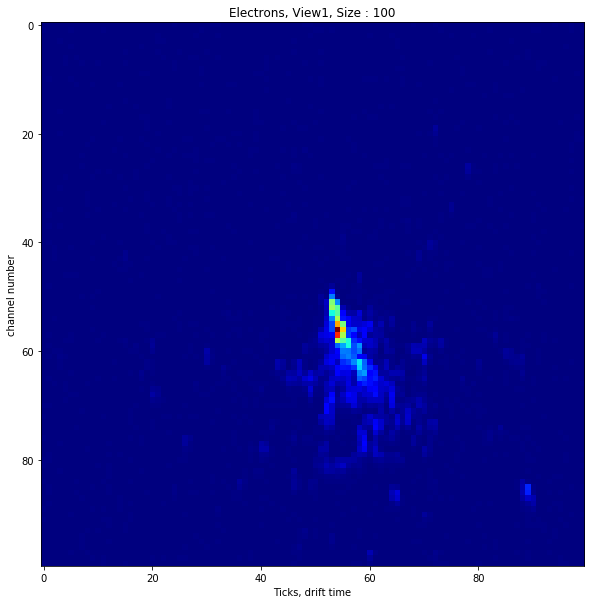

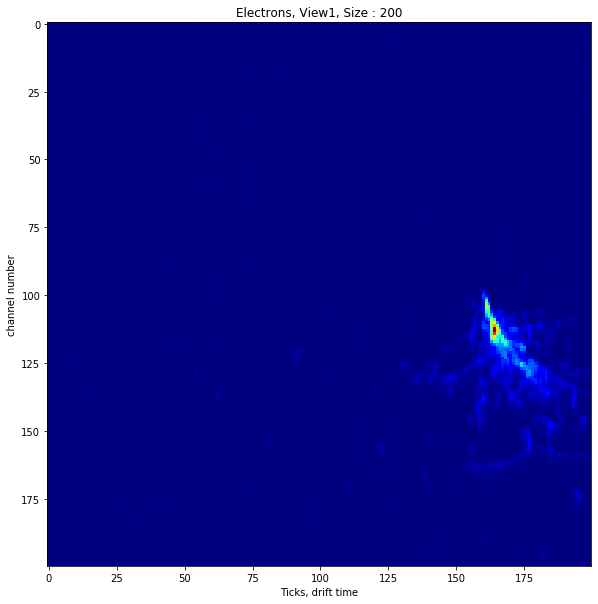

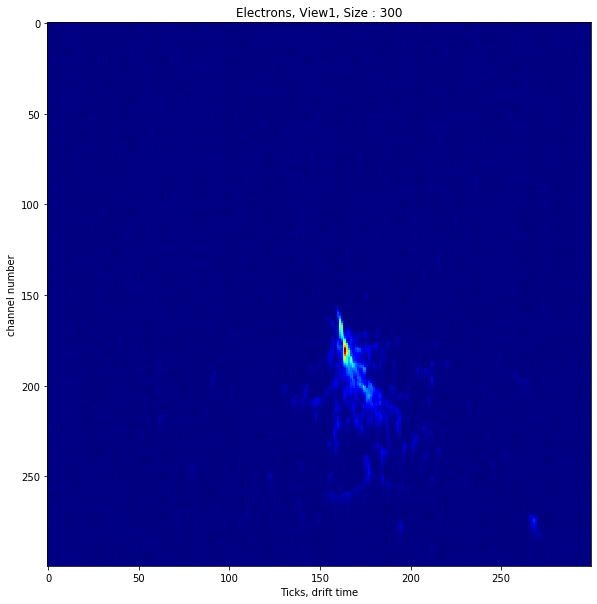

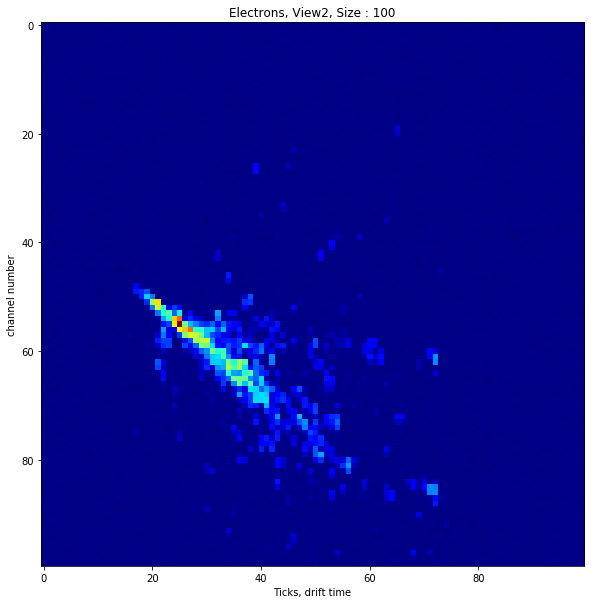

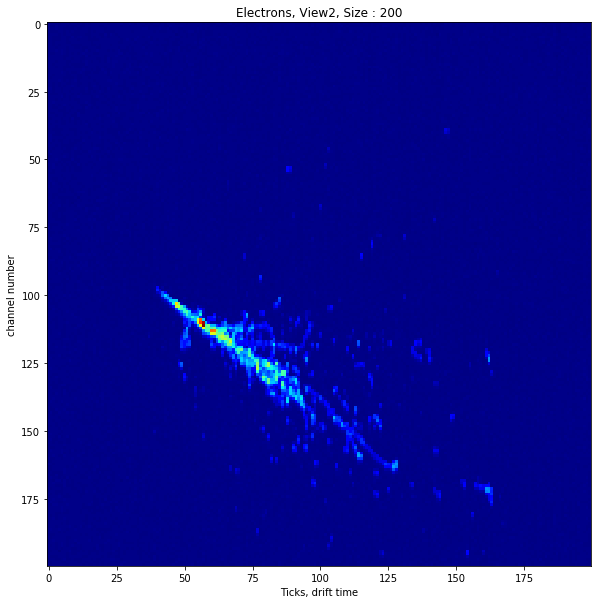

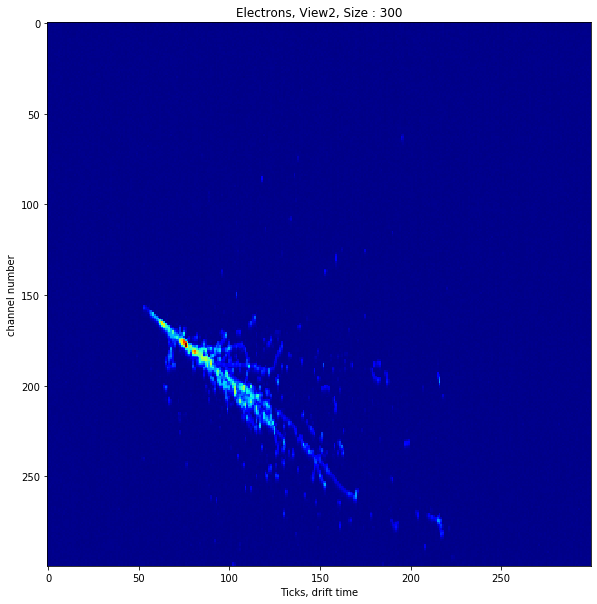

In [57]:
for i in range(1,4):
    v1red=maxpool(v1,100*i,100*i)
    fig = plt.figure()
    plt.title("Electrons, View1, Size : {}".format(100*i))
    plt.ylabel("channel number")
    plt.xlabel("Ticks, drift time")
    plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(10, 10) ##grey scale

for i in range(1,4):
    v2red=maxpool(v2,100*i,100*i)
    fig = plt.figure()
    plt.title("Electrons, View2, Size : {}" .format(100*i))
    plt.ylabel("channel number")
    plt.xlabel("Ticks, drift time")
    plt.imshow(v2red.T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(10, 10) ##grey scale

# Muons
The code from above, it is used in a function called displayed in funciones.py.

In [70]:
# definition of the function display, which is basically what we have done before
def display(Event = 0,save = False):
    w=1280
    h=1667
    ### Open Wave form file
    file = uproot.open("/scratch/deandres/MC/alongZ_2_3GeV/Muons/raw/raw.root") ### you may have to change the path as you wish
    tree=file["analysistree"]["anatree"] 
    ADC=tree['RawWaveform_ADC'] # define the object ADC from the tree
    basketcache={}
    lazy=ADC.lazyarray(basketcache=basketcache)
    im=lazy[Event].reshape((w,h))
    v1=im[0:320,:]
    v2=im[320:,:]
    fig = plt.figure()
    plt.imshow(v1.T,cmap = 'jet', interpolation='none')
    fig.set_size_inches(10, 10)
    plt.ylabel("Ticks, drift time ")
    plt.xlabel("channel View1")
    plt.show()
    if save:
        plt.save("view1.png")
        
    plt.imshow(v2.T,cmap = 'jet', interpolation='none') ##grey scale
    fig.set_size_inches(10, 10)
    plt.ylabel("Ticks, drift time ")
    plt.xlabel("channel View2")
    plt.show()
    if save:
        plt.save("view2.png")
    
    ### open paraneters file. 
    En=[]
    x=[]
    y=[]
    z=[]
    theta=[]
    phi=[]
    file = uproot.open("/scratch/deandres/MC/alongZ_2_3GeV/Muons/gen/gen.root")
    tree = file["analysistree"]["anatree"]
    En = np.append(En,tree.array(b'MCTruth_Generator_StartEnergy').flatten())
    x = np.append(x,tree.array(b'MCTruth_Generator_StartPoint_X').flatten())
    y = np.append(y,tree.array(b'MCTruth_Generator_StartPoint_Y').flatten())
    z = np.append(z,tree.array(b'MCTruth_Generator_StartPoint_Z').flatten())
    theta = np.append(theta,tree.array(b'MCTruth_Generator_StartDirection_Theta').flatten())
    phi = np.append(phi,tree.array(b'MCTruth_Generator_StartDirection_Phi').flatten())

    
    
    
    
    
    print("The event is generated according to the following parameters")
    print("E = ",round(En[Event],2), 'GeV')
    print("-"*40)
    print('x0 = ',round(x[Event],2))
    print('y0 = ',round(y[Event],2))
    print('z0 = ',round(z[Event],2))
    print("-"*40)
    print('theta0 = ',round(theta[Event],2))
    print('phi0 = ',round(phi[Event],2))
    
    ## return the two images as numpy arrays
    return v1, v2 

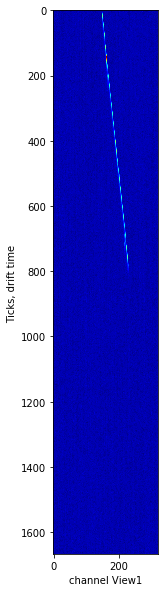

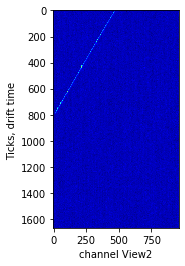

The event is generated according to the following parameters
E =  2.9 GeV
----------------------------------------
x0 =  0.0
y0 =  22.03
z0 =  5.79
----------------------------------------
theta0 =  70.34
phi0 =  -10.19


In [91]:
v1,v2 = display()

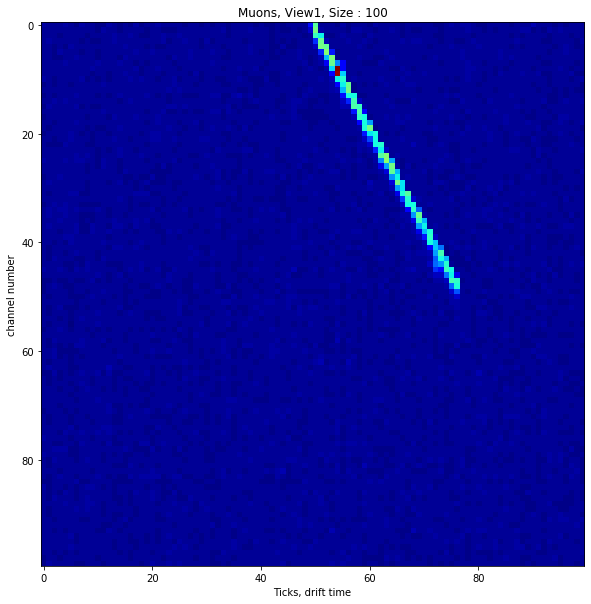

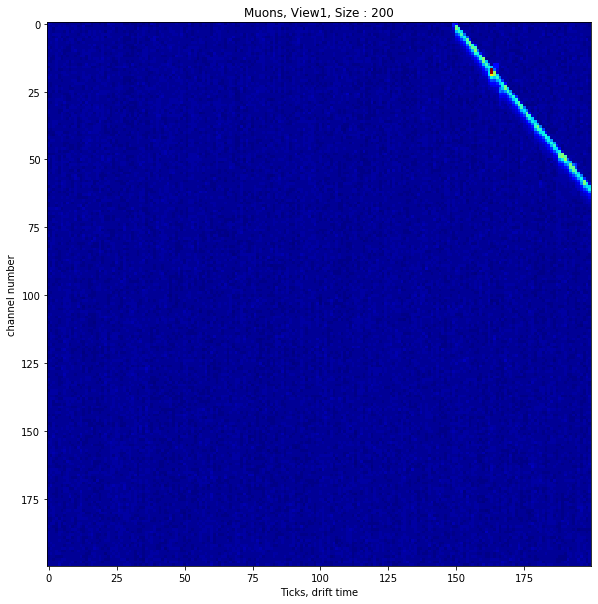

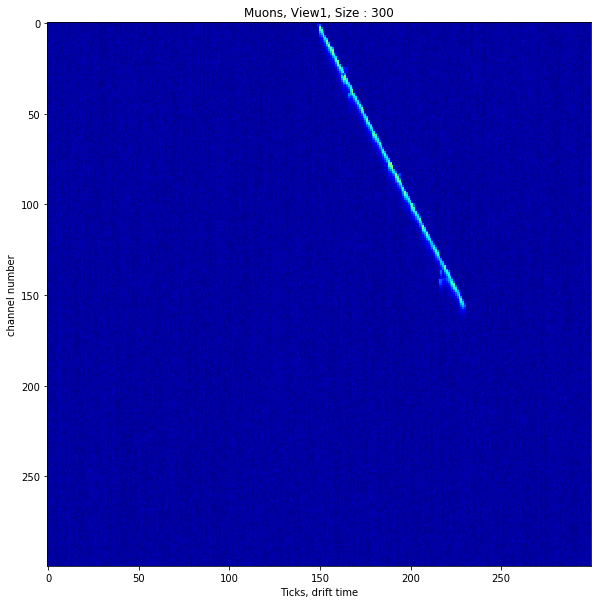

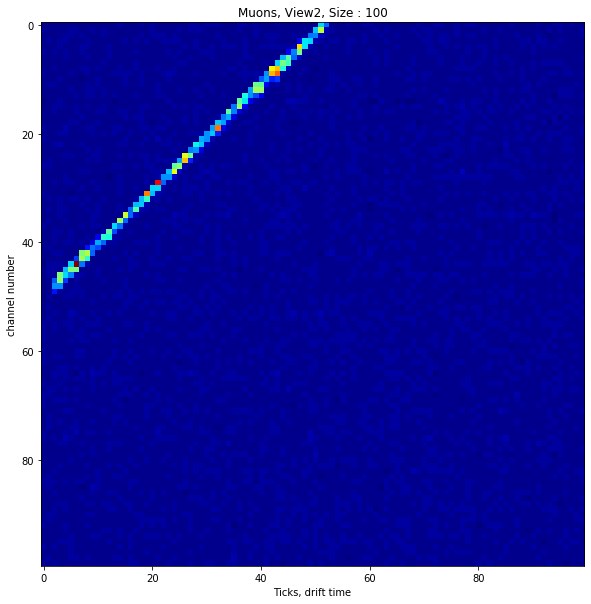

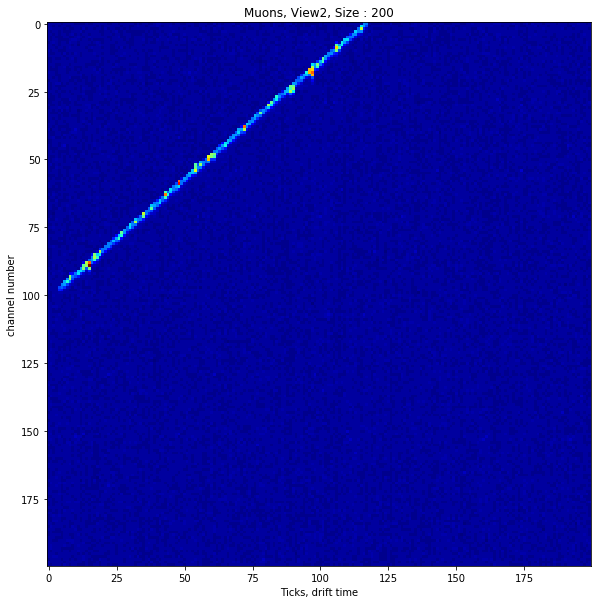

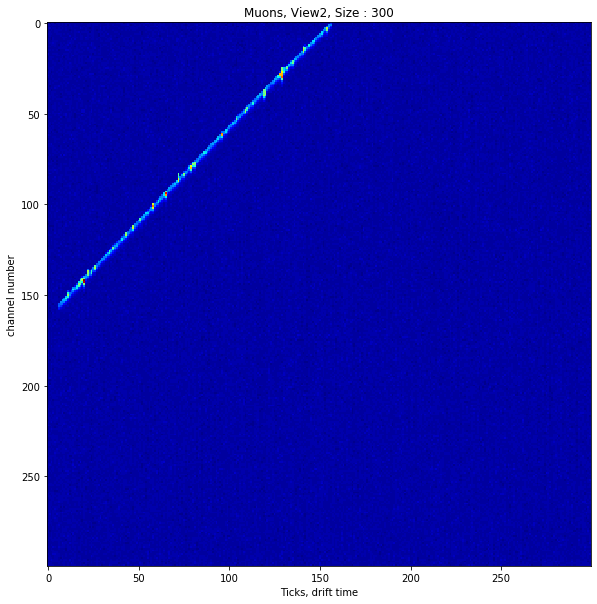

In [92]:
for i in range(1,4):
    v1red=maxpool(v1,100*i,100*i)
    fig = plt.figure()
    plt.title("Muons, View1, Size : {}".format(100*i))
    plt.ylabel("channel number")
    plt.xlabel("Ticks, drift time")
    plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(10, 10) ##grey scale

for i in range(1,4):
    v2red=maxpool(v2,100*i,100*i)
    fig = plt.figure()
    plt.title("Muons, View2, Size : {}" .format(100*i))
    plt.ylabel("channel number")
    plt.xlabel("Ticks, drift time")
    plt.imshow(v2red.T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(10, 10) ##grey scale

# Save images using uproot: not good yet

In [2]:
f=uproot.recreate("example.root")
f["tree"] = uproot.newtree({"branch": "int32"})
f["tree"].extend({"branch": v1red.flatten()})

NameError: name 'v1red' is not defined

In [13]:
f["tree"] # defined the object TTree to store our files

In [14]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

file1= uproot.open("example.root")
tree1=file1["tree"]
tree1.keys()

[b'branch']

In [12]:
imagen=tree1.array(b'branch')
imagen=imagen.reshape(100,100)

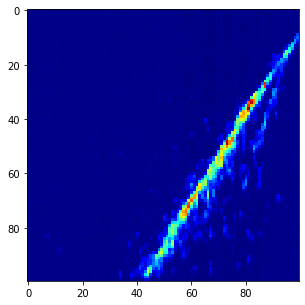

In [13]:
fig = plt.figure(frameon = False)
plt.imshow(imagen.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

The point about uproot is that it cannot save the images as different events.The images must be stored and then reshaped. 

In [107]:
np.save("example",imagen) ## esier but double the space in Disk, might not be useful. For a simple example
#it can be used.

# Saving images 
* The reasonably efficient way

In [24]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from funciones import maxpool
from ROOT import TFile, TTree

#### observation 

### my CIEMAT PC does not have jupyter root, so that this will be run in a Python script.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-d8a59b87ef0b>", line 5, in <module>
    from ROOT import TFile, TTree
  File "/usr/lib64/python3.6/site-packages/ROOT.py", line 531, in _importhook
    return _orig_ihook( name, *args, **kwds )
  File "/usr/lib64/python3.6/site-packages/ROOT.py", line 832, in <module>
    import JupyROOT
  File "/usr/lib64/python3.6/site-packages/ROOT.py", line 531, in _importhook
    return _orig_ihook( name, *args, **kwds )
  File "/usr/lib64/python3.6/site-packages/ROOT.py", line 531, in _importhook
    return _orig_ihook( name, *args, **kwds )
ModuleNotFoundError: No module named 'JupyROOT'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 203

ModuleNotFoundError: No module named 'JupyROOT'

In [2]:
def reducir(number_of_files=int(10)): #izquierda sin defoult derecha con.
    #### imput is the number of files to consider

    for i in range(0,number_of_files):

        file = uproot.open("{}-RecoFull-Parser.root".format(i))
        tree=file["analysistree"]["anatree"] 
        ADC = tree.array( b'RecoWaveform_ADC')
        NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
        Nticks=tree.array(b'RecoWavefoerm_NumberOfTicksInAllChannels')
        NTracks=tree.array(b'NumberOfTracks')
        w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
        #print(w,h)

        ###here a loop over files
        newsize=319
        v=np.zeros((newsize,newsize,100*number_of_files))
        vred=v
        for i in range(0,100*number_of_files):
            todo=ADC[i].reshape((w,h))
            v1=todo[0:newsize,:]
            v[:,:,i] = maxpool(v1,newsize,newsize)
    #### output is the rediced images as a numpy array
    return v

In [3]:
def guardar(v,filename):
    ##########description#########
    # this function stores the np vector 'v' into a 'root file'. Due to memory reasons, the other options are not
    # as good as root files.
    
    ###FUNCTION####
    ######dependences#####
    #from ROOT import TFile, TTree
    #import numpy as np
    a=v.flatten()
    f = TFile(filename, 'recreate')
    t = TTree('mytree', 'tree')
    
    
    t.Branch('im', a, 'myarray[{}]/D'.format(int(a.shape[0])))
    
    
    
    t.Fill()
    f.Write()
    f.Close()
    ##### output is None, this function will save the reduced images as a root file, it is probably not 
    ##### convinient to use the array. 
    return None

In [8]:
def abrir(file,dim):
    ######description########
    #this function opens our root file, and gives us a numpy vector of the proper dimensions.
    
    file = uproot.open(file)
    tree=file[b'mytree;1']
    im=tree.array(b'im')
    im=im.reshape(dim)
    return im

## Test the functions
* observations, reducir is a pretty slow function, it would be nice to consider a vectorized form of the function
* guardar and abrir are pretty fast

In [12]:
v = reducir(1)

In [15]:
guardar(v,"try.root")

In [16]:
im =abrir("try.root",v.shape)

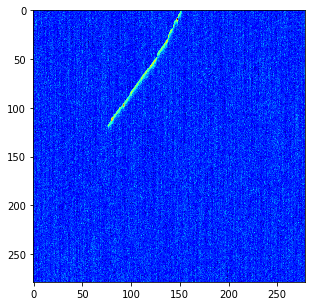

In [34]:
event=40
fig = plt.figure(frameon = False)
plt.imshow(im[:,:,event].T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

In [42]:
def dibujar(event,im):
    fig = plt.figure(frameon = False)
    plt.imshow(im[:,:,event].T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(5, 5) ##grey scale
    fig.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


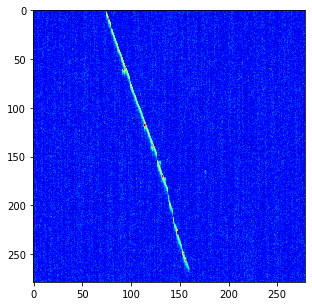

In [44]:
dibujar(6,im)